In [37]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import scoreatpercentile, linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### Functions

In [38]:
def voxelwise_corrs(patientlist, session, vasclabel):
    path = "/home/bpereira/func/"
    ses = session
    restpath = f"{ses}/{ses}-proc.feat/maps_to_corr/"

    lin_adjr2_happy = []
    quad_adjr2_happy = []
    lin_adjr2_angry = []
    quad_adjr2_angry = []
    lin_adjr2_vis = []
    quad_adjr2_vis = []

    count=5
    #pvalsh = []

    for sub in patientlist:

        happy_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE8_smoothed8.nii")
        angry_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE9_smoothed8.nii")
        vis_path = os.path.join(path,sub,restpath,f"{sub}_{ses}_mapCOPE4_smoothed8.nii")

        maskhappy_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE8_EMP_thr95.nii.gz"
        maskangry_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE9_EMP_thr95.nii.gz"
        maskvis_path = "/home/bpereira/func/HL/with_EMPs/randomiseGM_EMP/GM_COPE4_EMP_thr95.nii.gz"

        if vasclabel=='ASL':
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/perf-preproc/",sub,ses,"smoothed8_perfusion_MNI.nii")
        else:
            vasc_path = os.path.join("/home/mig_n2treatdata/derivatives/func-preproc/func-task_breathhold/",sub,ses,"smoothed8_CVR_single_delay6_deltapet_thrvar_MNI.nii")
            #print("entered")
    
        # load data
        happynii = nib.load(happy_path)
        happy = happynii.get_fdata()

        angrynii = nib.load(angry_path)
        angry = angrynii.get_fdata()

        visnii = nib.load(vis_path)
        vis = visnii.get_fdata()

        maskhappynii = nib.load(maskhappy_path)
        maskhappy = maskhappynii.get_fdata()

        maskangrynii = nib.load(maskangry_path)
        maskangry = maskangrynii.get_fdata()

        maskvisnii = nib.load(maskvis_path)
        maskvis = maskvisnii.get_fdata()

        vascnii = nib.load(vasc_path)
        vasc = vascnii.get_fdata()

        # cut due to ASLs FOV

        cuthappy = happy[:,:,16:68]
        cutangry = angry[:,:,16:68]
        cutvis = vis[:,:,16:68]
        cutmaskh = maskhappy[:,:,16:68]
        cutmaska = maskangry[:,:,16:68]
        cutmaskv = maskvis[:,:,16:68]

        cutvasc = vasc[:,:,16:68]

        # flatten

        flatcuthappy = cuthappy.flatten()
        flatcutangry = cutangry.flatten()
        flatcutvis = cutvis.flatten()

        flatcutvasc = cutvasc.flatten()

        # keep only areas from the mask

        maskhappy_ind = np.where(cutmaskh.flatten()==1)
        maskangry_ind = np.where(cutmaska.flatten()==1)
        maskvis_ind = np.where(cutmaskv.flatten()==1)

        # keep only activation areas

        #happy_actind = np.where(testhappy>0)
        #angry_actind = np.where(testangry>0)
        #vis_actind = np.where(testvis>0)

        # remove outliers from vasc maps

        qvasc1 = scoreatpercentile(flatcutvasc,1)
        qvasc99 = scoreatpercentile(flatcutvasc,99)

        # find index of non outliers

        vasc_non_outliers_ind = np.where((flatcutvasc > qvasc1) & (flatcutvasc < qvasc99))

        # keep only non outliers from neuronal and vasc maps and areas from the mask

        commonhappy_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskhappy_ind)
        commonangry_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskangry_ind)
        commonvis_nonoutliers_mask_ind = np.intersect1d(vasc_non_outliers_ind,maskvis_ind)

        # select only common voxels

        flatfinalhappy= flatcuthappy[commonhappy_nonoutliers_mask_ind]
        flatfinalangry = flatcutangry[commonangry_nonoutliers_mask_ind]
        flatfinalvis = flatcutvis[commonvis_nonoutliers_mask_ind]

        flatfinalvaschappy = flatcutvasc[commonhappy_nonoutliers_mask_ind]
        flatfinalvascangry = flatcutvasc[commonangry_nonoutliers_mask_ind]
        flatfinalvascvis = flatcutvasc[commonvis_nonoutliers_mask_ind]


        # correlations

        # happy vs vasc

        if len(flatfinalhappy)>0:

            x = flatfinalvaschappy
            y = flatfinalhappy
            slopeh, intercepth, r_valueh, p_valueh, std_errh = linregress(x, y)
            r2h = r_valueh**2
            adj_r2h = 1 - (1 - r2h) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

            lin_adjr2_happy += [adj_r2h]

            hcoefs = np.polyfit(x,y,deg=2)
            yfitquadh = np.polyval(hcoefs, x)
            yresidquad = y - yfitquadh
            SSresidquad = np.sum(yresidquad ** 2)
            SStotalquad = (len(y) - 1) * np.var(y)
            rsqquad = 1 - SSresidquad / SStotalquad
            rsq_adjquadh = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

            quad_adjr2_happy += [rsq_adjquadh]
        else:
            print(f'Map happy empty for patient {sub}')

        # angry vs vasc 

        if len(flatfinalangry)>0:

            x = flatfinalvascangry
            y = flatfinalangry
            slopea, intercepta, r_valuea, p_valuea, std_erra = linregress(x, y)
            r2a = r_valuea**2
            adj_r2a = 1 - (1 - r2a) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

            lin_adjr2_angry += [adj_r2a]

            acoefs = np.polyfit(x,y,deg=2)
            yfitquada = np.polyval(acoefs, x)
            yresidquad = y - yfitquada
            SSresidquad = np.sum(yresidquad ** 2)
            SStotalquad = (len(y) - 1) * np.var(y)
            rsqquad = 1 - SSresidquad / SStotalquad
            rsq_adjquada = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

            quad_adjr2_angry += [rsq_adjquada]
        else: 
            print(f"Map angry for patient {sub} empty")

        # vis vs vasc 

        if len(flatfinalvis)>0:

            x = flatfinalvascvis
            y = flatfinalvis
            slopev, interceptv, r_valuev, p_valuev, std_errv = linregress(x, y)
            r2v = r_valuev**2
            adj_r2v = 1 - (1 - r2v) * (len(y) - 1) / (len(y)  - 1 - 1) # o valor de p neste caso = 1, por se tratar de linear reg

            lin_adjr2_vis += [adj_r2v]
            #pvalsv += [p_valuev]

            vcoefs = np.polyfit(x,y,deg=2)
            yfitquadv = np.polyval(vcoefs, x)
            yresidquad = y - yfitquadv
            SSresidquad = np.sum(yresidquad ** 2)
            SStotalquad = (len(y) - 1) * np.var(y)
            rsqquad = 1 - SSresidquad / SStotalquad
            rsq_adjquadv = 1 - (1 - rsqquad) * (len(y) - 1) / (len(y) - 2 - 1) # p=2, quadratic

            quad_adjr2_vis += [rsq_adjquadv]
        else:
            print(f"Map visual empty for {sub}")
        

        count += 1
        if 5<count<8 and (session=='ses-interictal' or session=='ses-midcycle'):
            #count += 2
            plt.figure()

            if len(flatfinalhappy)>0:
                x = flatfinalvaschappy
                y = flatfinalhappy
                plt.scatter(x, y, color='red')
                plt.plot(x, slopeh * x + intercepth, color='blue', label='linear')
                x_regression = np.linspace(min(x), max(x), 100)
                y_regression = np.polyval(hcoefs, x_regression)
                plt.plot(x_regression, y_regression, color='green', label='quad')
                plt.title(f'Happy Network vs {vasclabel}')
                plt.ylabel('Happy Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()

            if len(flatfinalangry>0):
                x = flatfinalvascangry
                y = flatfinalangry
                plt.figure()
                plt.scatter(x, y, color='red')
                plt.plot(x, slopea * x + intercepta, color='blue', label='linear')
                x_regression = np.linspace(min(x), max(x), 100)
                y_regression = np.polyval(acoefs, x_regression)
                plt.plot(x_regression, y_regression, color='green', label='quad')
                plt.title(f'Angry Network vs {vasclabel}')
                plt.ylabel('Angry Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()

            if len(flatfinalvis)>0:
                x = flatfinalvascvis
                y = flatfinalvis
                plt.scatter(x, y, color='red')
                plt.plot(x, slopev * x + interceptv, color='blue', label='linear')
                x_regression = np.linspace(min(x), max(x), 100)
                y_regression = np.polyval(vcoefs, x_regression)
                plt.plot(x_regression, y_regression, color='green', label='quad')
                plt.title(f'Visual Network vs {vasclabel}')
                plt.ylabel('Visual Network')
                plt.xlabel({vasclabel})
                plt.legend()
                plt.show()



    return lin_adjr2_happy,lin_adjr2_angry,lin_adjr2_vis,quad_adjr2_happy,quad_adjr2_angry,quad_adjr2_vis



In [39]:
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()

def boxplots(linlist,quadlist,ses,metric):
    ticks = ['Happy Network', 'Angry Network', 'Visual Network']

    linear_plotint = plt.boxplot(linlist,positions=np.array(np.arange(len(linlist)))*2.0-0.35, widths=0.6)
    quad_plotint = plt.boxplot(quadlist,positions=np.array(np.arange(len(quadlist)))*2.0+0.35,widths=0.6)
    
    #plt.figure()
    define_box_properties(linear_plotint, '#D7191C', 'Linear')
    define_box_properties(quad_plotint, '#2C7BB6', 'Quadratic')

    plt.ylabel('Adjusted r-squared')
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(-0.02,0.18)

    plt.title(f'Voxelwise correlation Between Neuronal maps and {metric} ({ses})')

    plt.figure()

def boxplots2(linlist,quadlist,net,metric):
    ticks = ['Midcycle','Premenstrual','Interictal','Preictal','Ictal','Postictal']

    linear_plotint = plt.boxplot(linlist,positions=np.array(np.arange(len(linlist)))*2.0-0.35, widths=0.6)
    quad_plotint = plt.boxplot(quadlist,positions=np.array(np.arange(len(quadlist)))*2.0+0.35,widths=0.6)
    
    #plt.figure()
    define_box_properties(linear_plotint, '#D7191C', 'Linear')
    define_box_properties(quad_plotint, '#2C7BB6', 'Quadratic')

    plt.ylabel('Adjusted r-squared')
    plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(-0.02,0.18)

    plt.title(f'Voxelwise correlation Between {net} and {metric}')

    plt.figure()


# KDEF

## Patients Correlations

In [40]:
patients_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_preictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patients_ictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patients_postictal = ["sub-patient001","sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034","sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsASL_interictal = ["sub-patient002","sub-patient003","sub-patient005","sub-patient006","sub-patient007","sub-patient008","sub-patient009","sub-patient012","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_preictal = ["sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient013", "sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsASL_ictal = ["sub-patient001","sub-patient003","sub-patient004","sub-patient005","sub-patient006","sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"]
patientsASL_postictal = ["sub-patient003","sub-patient005","sub-patient006","sub-patient008","sub-patient009","sub-patient012","sub-patient034", "sub-patient038","sub-patient041", "sub-patient043","sub-patient045"]

patientsCVR_interictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_preictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]
patientsCVR_ictal = ["sub-patient013","sub-patient034","sub-patient038","sub-patient041","sub-patient045","sub-patient052"] # !!! SUB-PATIENT004 NOT INCLUDED FOR NOW
patientsCVR_postictal = ["sub-patient034","sub-patient038","sub-patient041","sub-patient043","sub-patient045"]

In [41]:
# we only want patients with vascular AND neuronal maps

def intersection(list1,list2):
    return [element for element in list1 if element in list2]

neurowASL_interictal = intersection(patients_interictal,patientsASL_interictal)
#print(len(neurowCVR_interictal))
neurowASL_preictal = intersection(patients_preictal,patientsASL_preictal)
#print(len(neurowASL_preictal))
neurowASL_ictal = intersection(patients_ictal,patientsASL_ictal)
#print(len(neurowASL_ictal))
neurowASL_postictal = intersection(patients_postictal,patientsASL_postictal)
#print(len(neurowASL_postictal))

neurowCVR_interictal = intersection(patients_interictal,patientsCVR_interictal)
#print(len(neurowCVR_interictal))
neurowCVR_preictal = intersection(patients_preictal,patientsCVR_preictal)
#print(len(neurowCVR_preictal))
neurowCVR_ictal = intersection(patients_ictal,patientsCVR_ictal)
#print(len(neurowCVR_ictal))
neurowCVR_postictal = intersection(patients_postictal,patientsCVR_postictal)
#print(len(neurowCVR_postictal))


### ASL

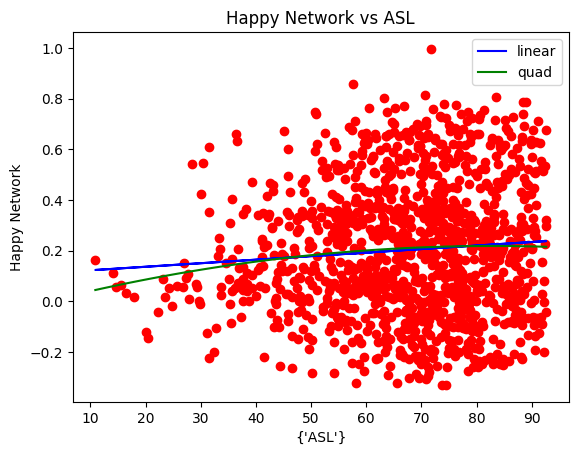

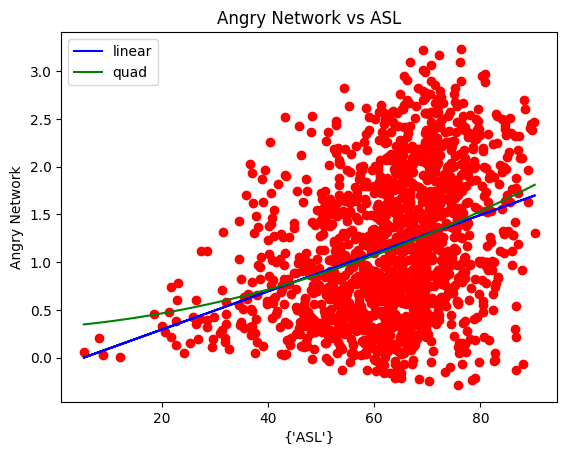

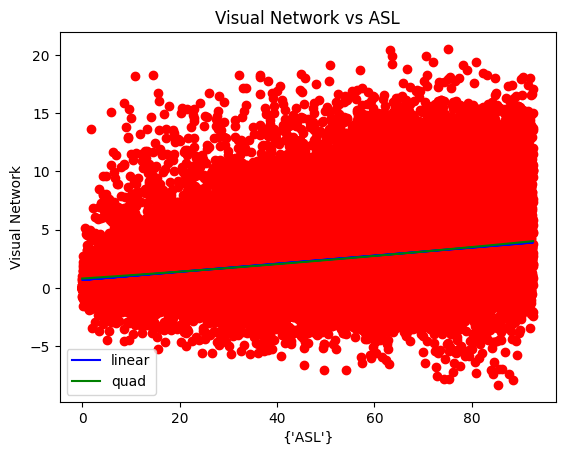

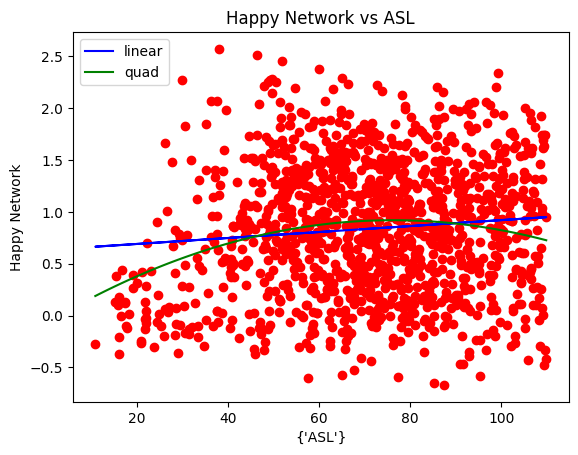

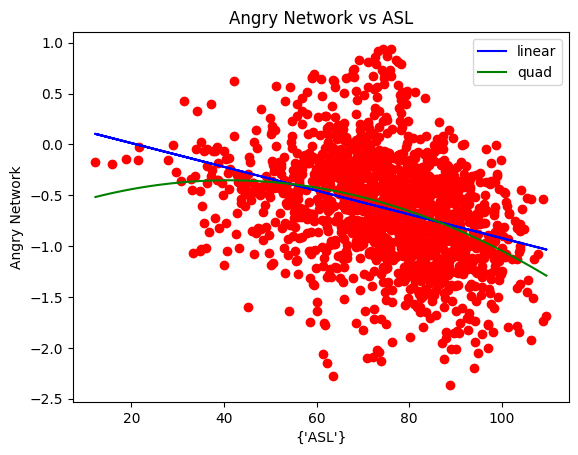

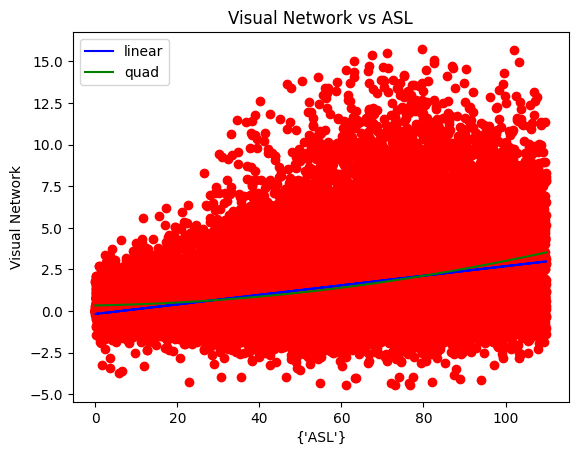

In [42]:
# ASL correlations 

# interictal

[ASLlinH_int,ASLlinA_int,ASLlinV_int,ASLquadH_int,ASLquadA_int,ASLquadV_int] = voxelwise_corrs(neurowASL_interictal,'ses-interictal','ASL')

# preictal

[ASLlinH_preict,ASLlinA_preict,ASLlinV_preict,ASLquadH_preict,ASLquadA_preict,ASLquadV_preict] = voxelwise_corrs(neurowASL_preictal,'ses-preictal','ASL')

# ictal 

[ASLlinH_ict,ASLlinA_ict,ASLlinV_ict,ASLquadH_ict,ASLquadA_ict,ASLquadV_ict] = voxelwise_corrs(neurowASL_ictal,'ses-ictal','ASL')

# postictal

[ASLlinH_postict,ASLlinA_postict,ASLlinV_postict,ASLquadH_postict,ASLquadA_postict,ASLquadV_postict] = voxelwise_corrs(neurowASL_postictal,'ses-postictal','ASL')



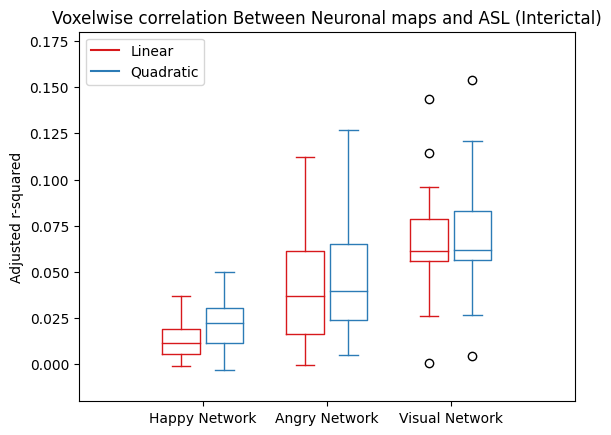

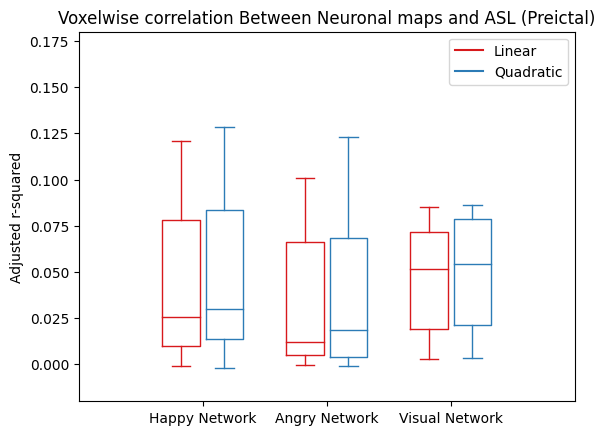

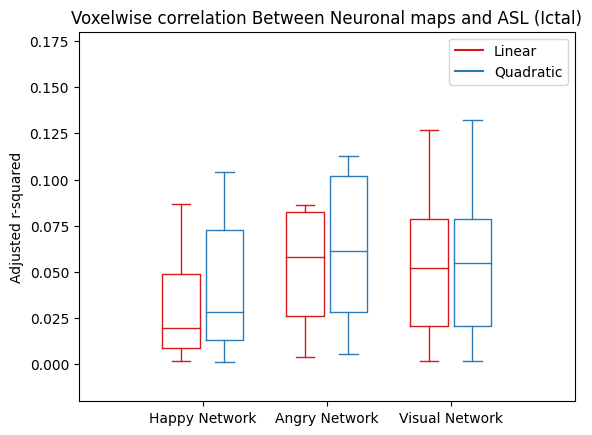

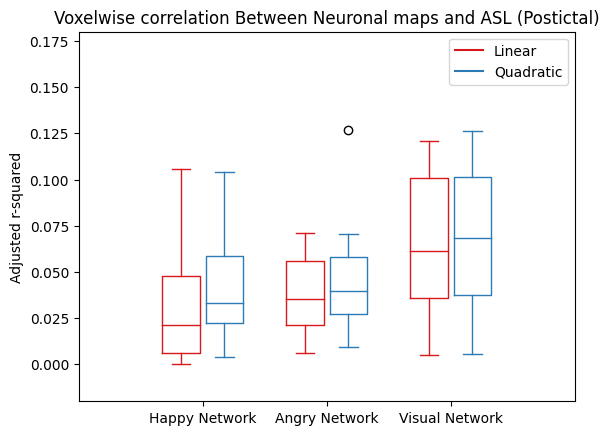

<Figure size 640x480 with 0 Axes>

In [43]:
boxplots([ASLlinH_int,ASLlinA_int,ASLlinV_int],[ASLquadH_int,ASLquadA_int,ASLquadV_int],"Interictal","ASL")
boxplots([ASLlinH_preict,ASLlinA_preict,ASLlinV_preict],[ASLquadH_preict,ASLquadA_preict,ASLquadV_preict],"Preictal","ASL")
boxplots([ASLlinH_ict,ASLlinA_ict,ASLlinV_ict],[ASLquadH_ict,ASLquadA_ict,ASLquadV_ict],"Ictal","ASL")
boxplots([ASLlinH_postict,ASLlinA_postict,ASLlinV_postict],[ASLquadH_postict,ASLquadA_postict,ASLquadV_postict],"Postictal","ASL")

### CVR

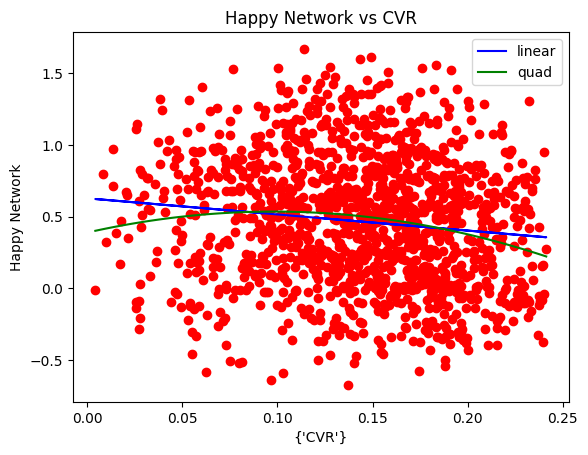

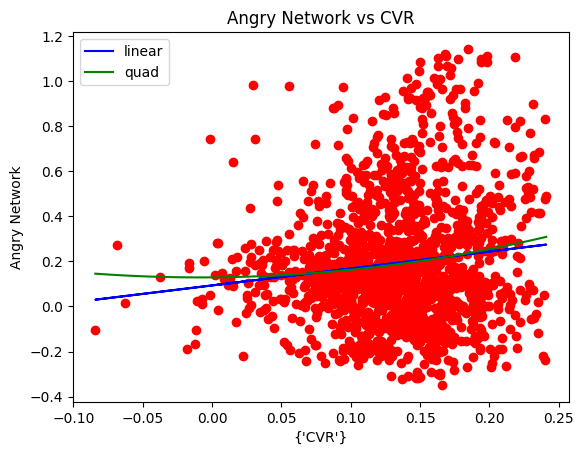

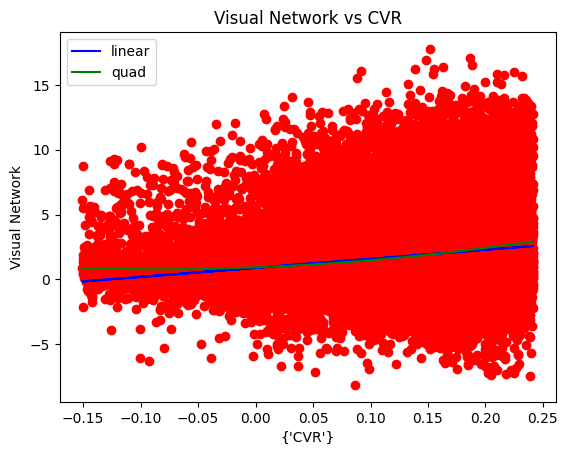

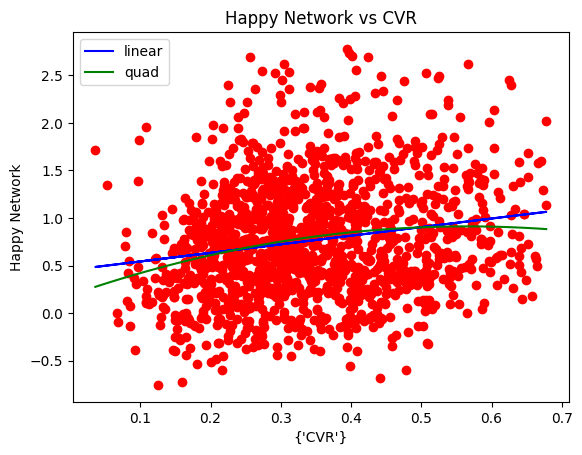

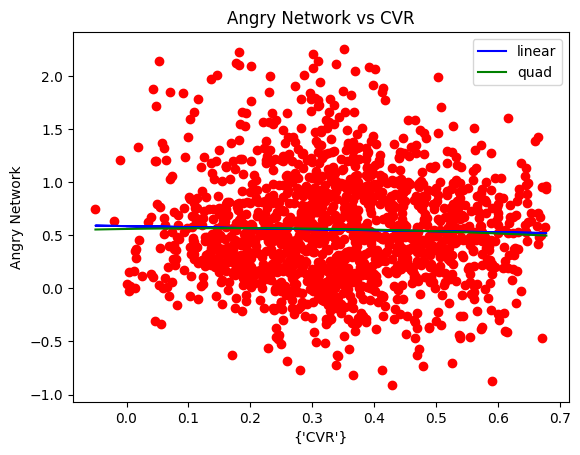

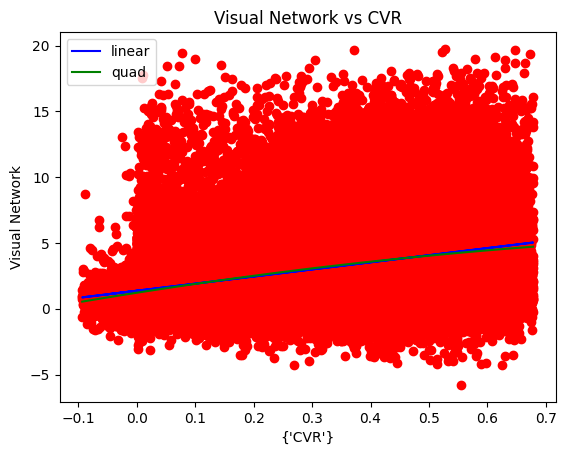

In [44]:
# CVR correlations

# interictal

[CVRlinH_int,CVRlinA_int,CVRlinV_int,CVRquadH_int,CVRquadA_int,CVRquadV_int] = voxelwise_corrs(neurowCVR_interictal,'ses-interictal','CVR')

# preictal

[CVRlinH_preict,CVRlinA_preict,CVRlinV_preict,CVRquadH_preict,CVRquadA_preict,CVRquadV_preict] = voxelwise_corrs(neurowCVR_preictal,'ses-preictal','CVR')

# ictal 

[CVRlinH_ict,CVRlinA_ict,CVRlinV_ict,CVRquadH_ict,CVRquadA_ict,CVRquadV_ict] = voxelwise_corrs(neurowCVR_ictal,'ses-ictal','CVR')

# postictal

[CVRlinH_postict,CVRlinA_postict,CVRlinV_postict,CVRquadH_postict,CVRquadA_postict,CVRquadV_postict] = voxelwise_corrs(neurowCVR_postictal,'ses-postictal','CVR')

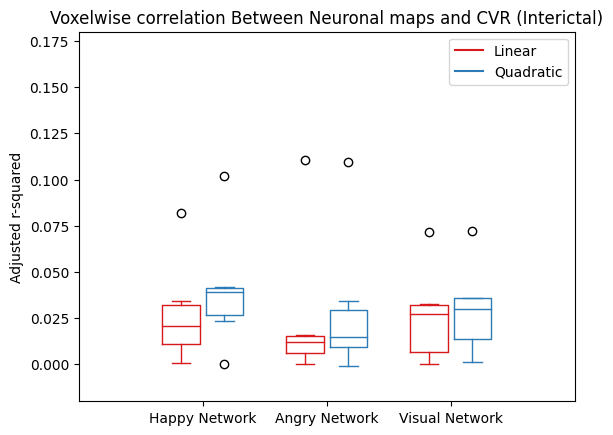

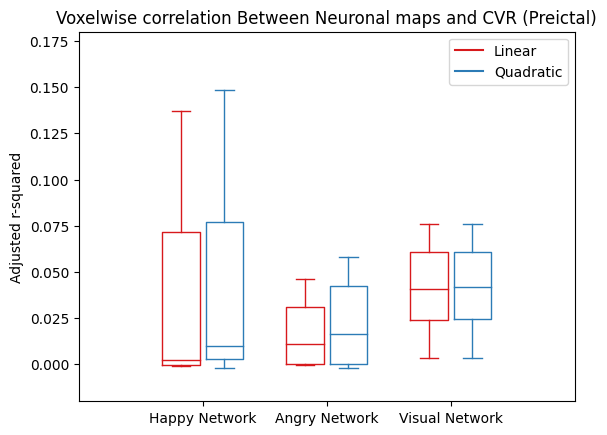

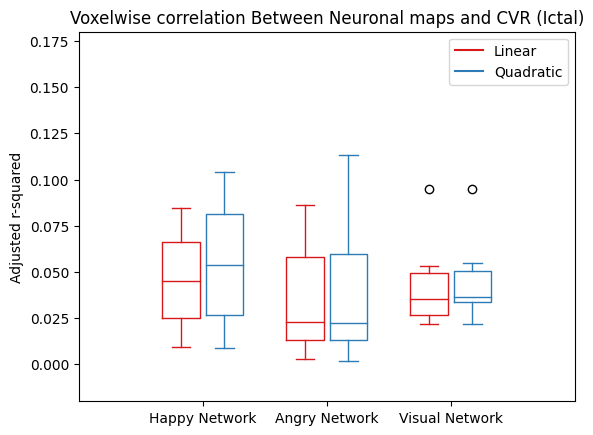

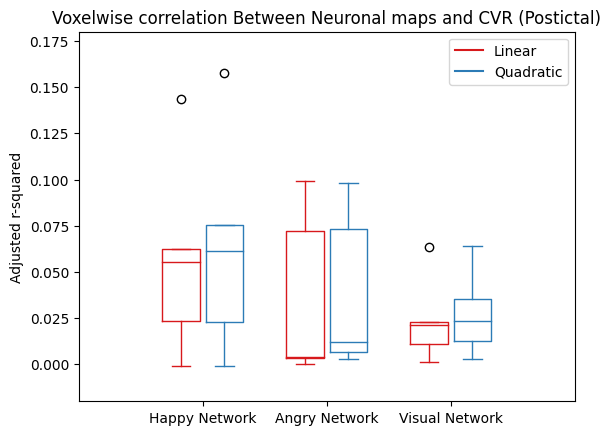

<Figure size 640x480 with 0 Axes>

In [45]:
boxplots([CVRlinH_int,CVRlinA_int,CVRlinV_int],[CVRquadH_int,CVRquadA_int,CVRquadV_int],"Interictal","CVR")
boxplots([CVRlinH_preict,CVRlinA_preict,CVRlinV_preict],[CVRquadH_preict,CVRquadA_preict,CVRquadV_preict],"Preictal","CVR")
boxplots([CVRlinH_ict,CVRlinA_ict,CVRlinV_ict],[CVRquadH_ict,CVRquadA_ict,CVRquadV_ict],"Ictal","CVR")
boxplots([CVRlinH_postict,CVRlinA_postict,CVRlinV_postict],[CVRquadH_postict,CVRquadA_postict,CVRquadV_postict],"Postictal","CVR")

## Controls Correlations

### ASL

In [46]:
controls_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]
controls_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]

ASLcontrols_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]
ASLcontrols_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control049","sub-control051"]

CVRcontrols_midcycle = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control033","sub-control046","sub-control048","sub-control051"]
CVRcontrols_premens = ["sub-control019","sub-control020","sub-control025","sub-control026","sub-control027","sub-control028","sub-control029","sub-control030","sub-control031","sub-control033","sub-control044","sub-control046","sub-control048","sub-control051"]

In [47]:
neurowCVR_midcycle = intersection(controls_midcycle,CVRcontrols_midcycle)
#print(len(neurowCVR_midcycle))
neurowCVR_premens = intersection(controls_premens,CVRcontrols_premens)
#print(len(neurowCVR_premens))

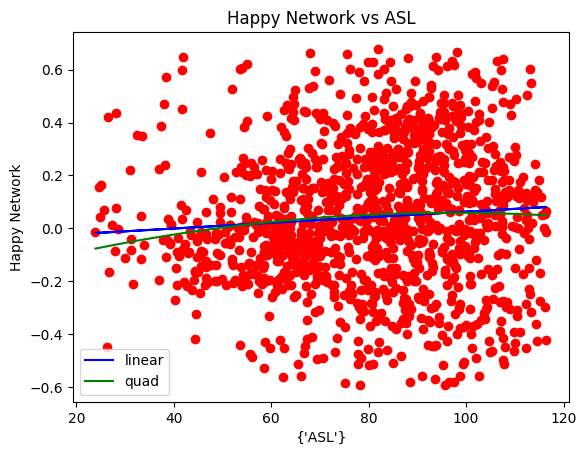

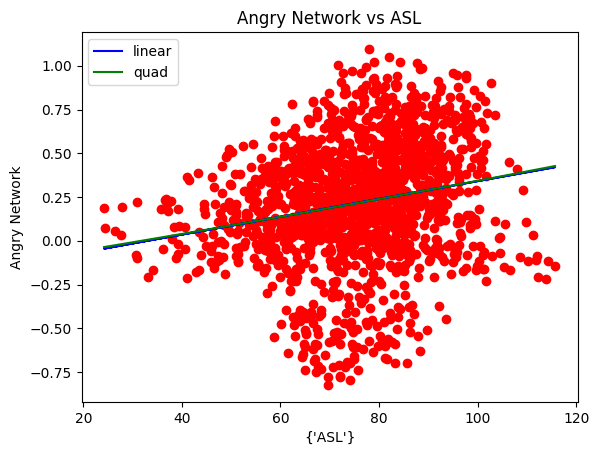

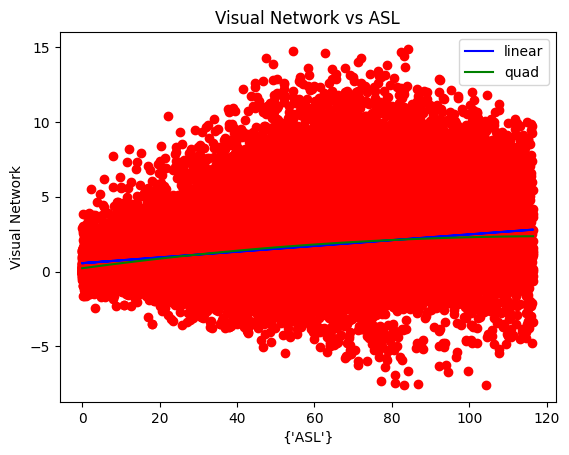

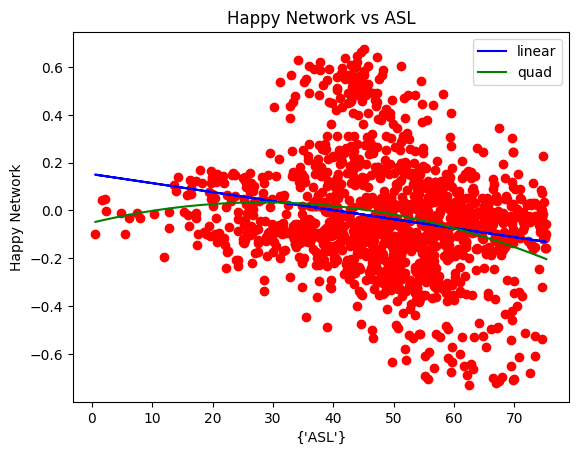

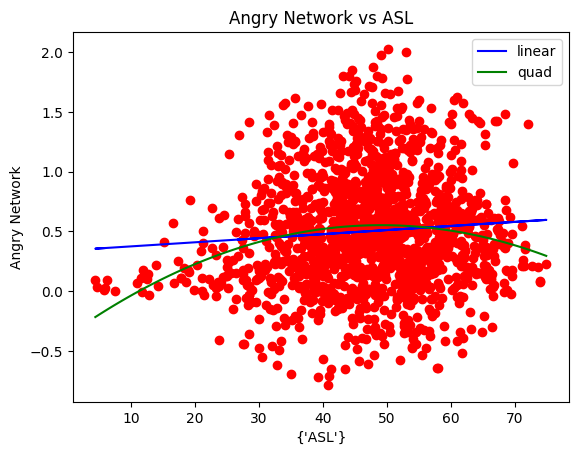

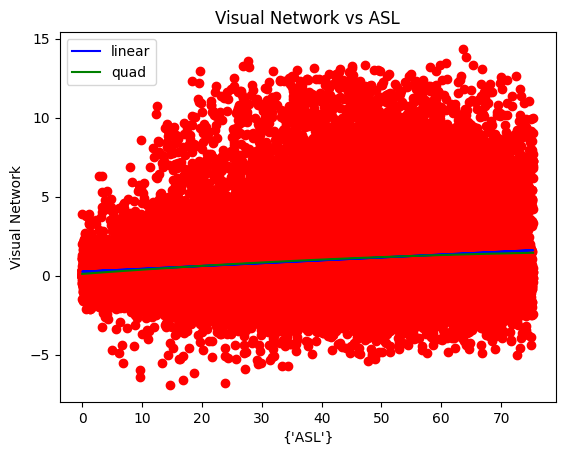

In [48]:
[ASLlinH_mid,ASLlinA_mid,ASLlinV_mid,ASLquadH_mid,ASLquadA_mid,ASLquadV_mid] = voxelwise_corrs(controls_midcycle,'ses-midcycle','ASL')
[ASLlinH_premens,ASLlinA_premens,ASLlinV_premens,ASLquadH_premens,ASLquadA_premens,ASLquadV_premens] = voxelwise_corrs(controls_premens,'ses-premenstrual','ASL')

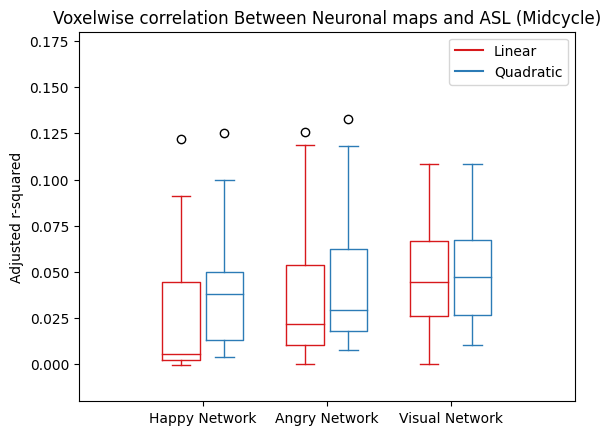

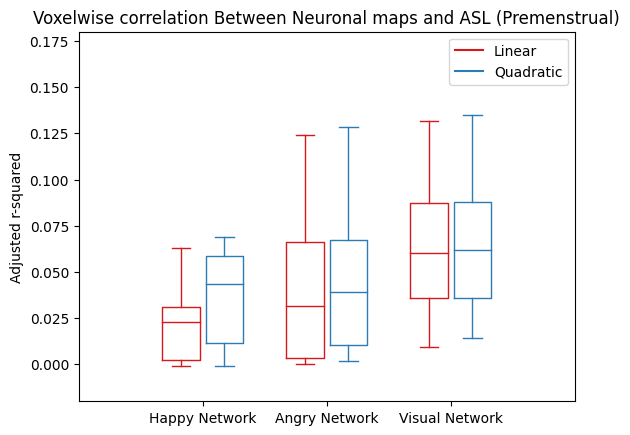

<Figure size 640x480 with 0 Axes>

In [49]:
boxplots([ASLlinH_mid,ASLlinA_mid,ASLlinV_mid],[ASLquadH_mid,ASLquadA_mid,ASLquadV_mid],"Midcycle","ASL")
boxplots([ASLlinH_premens,ASLlinA_premens,ASLlinV_premens],[ASLquadH_premens,ASLquadA_premens,ASLquadV_premens],"Premenstrual","ASL")

### CVR

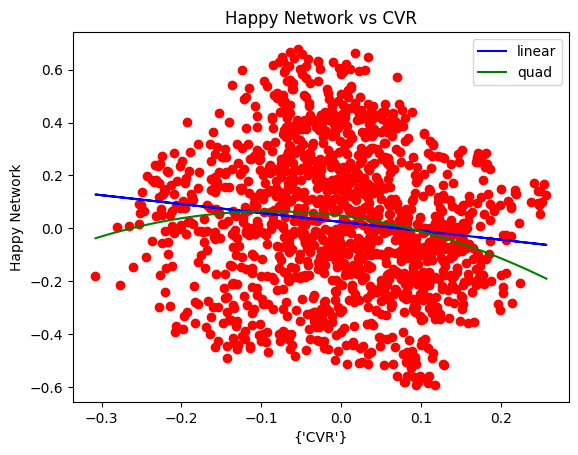

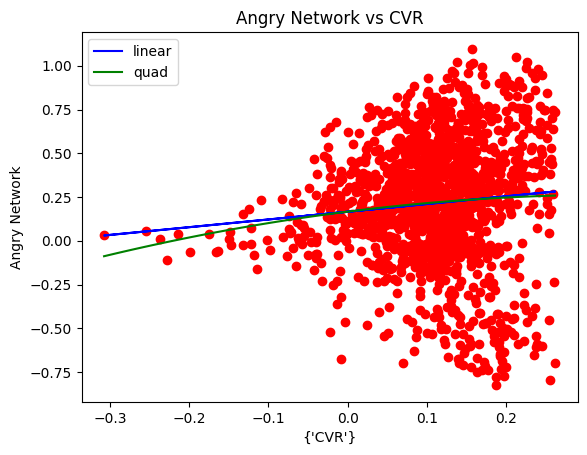

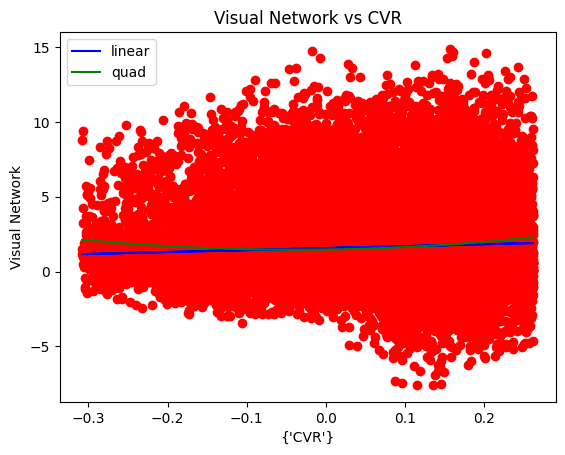

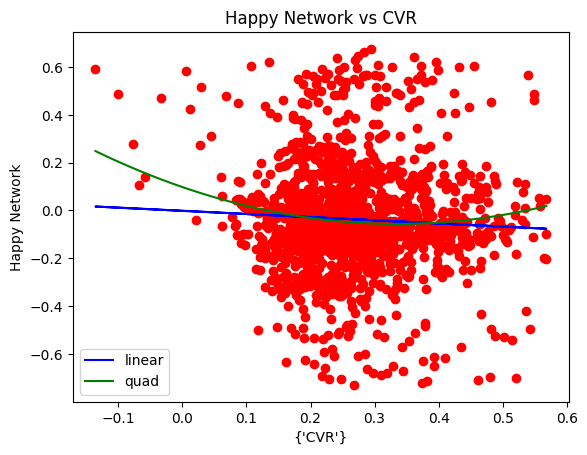

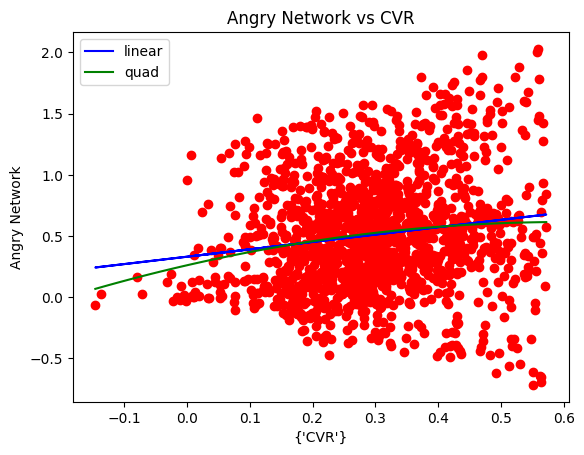

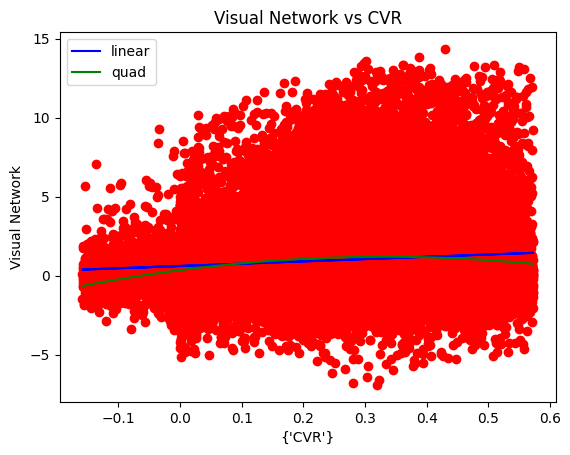

In [50]:
[CVRlinH_mid,CVRlinA_mid,CVRlinV_mid,CVRquadH_mid,CVRquadA_mid,CVRquadV_mid] = voxelwise_corrs(neurowCVR_midcycle,'ses-midcycle','CVR')
[CVRlinH_premens,CVRlinA_premens,CVRlinV_premens,CVRquadH_premens,CVRquadA_premens,CVRquadV_premens] = voxelwise_corrs(neurowCVR_premens,'ses-premenstrual','CVR')

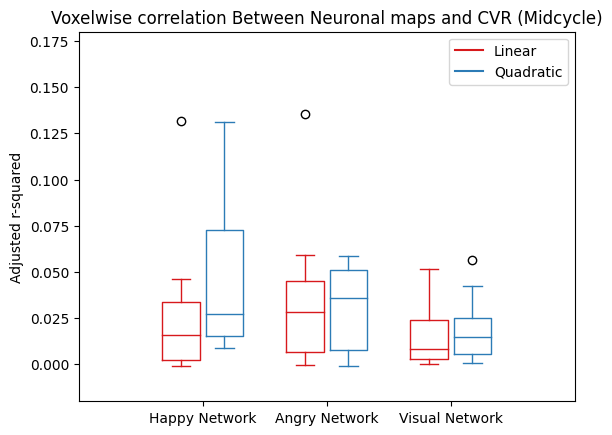

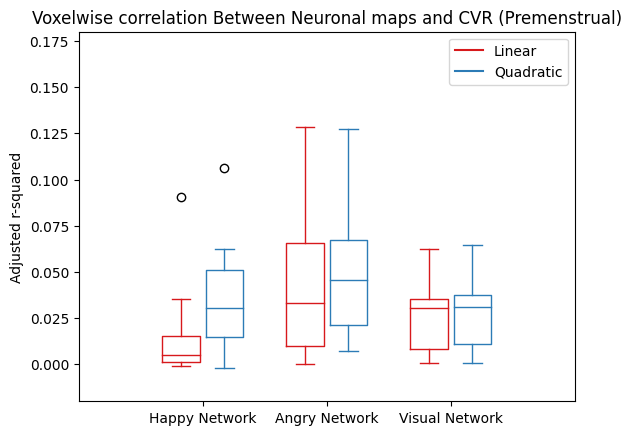

<Figure size 640x480 with 0 Axes>

In [51]:
boxplots([CVRlinH_mid,CVRlinA_mid,CVRlinV_mid],[CVRquadH_mid,CVRquadA_mid,CVRquadV_mid],"Midcycle","CVR")
boxplots([CVRlinH_premens,CVRlinA_premens,CVRlinV_premens],[CVRquadH_premens,CVRquadA_premens,CVRquadV_premens],"Premenstrual","CVR")

## Phases Boxplot

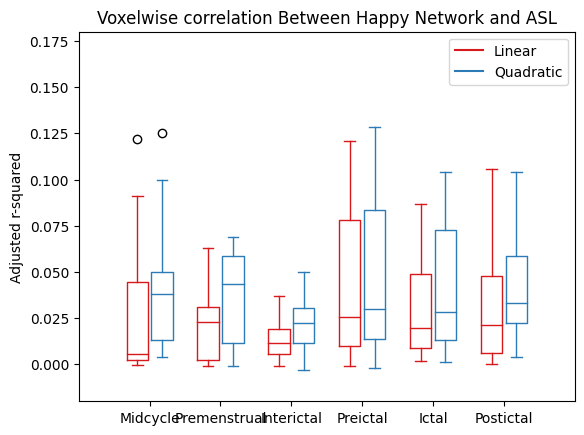

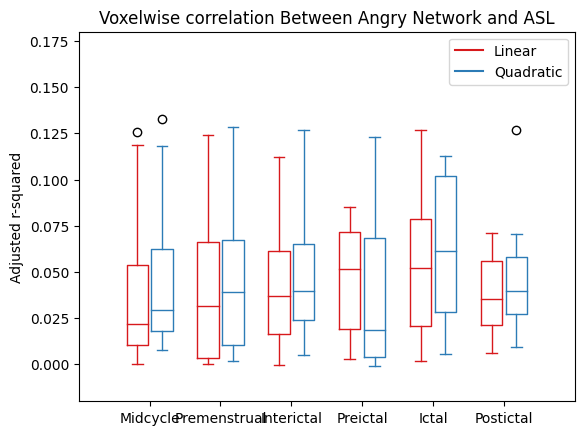

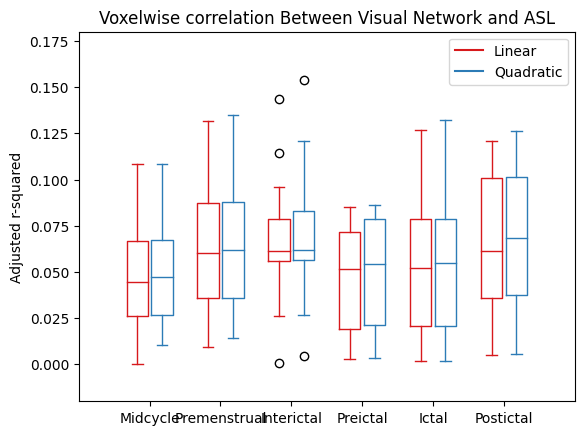

<Figure size 640x480 with 0 Axes>

In [52]:
linearplotshappy = [ASLlinH_mid, ASLlinH_premens, ASLlinH_int,ASLlinH_preict,ASLlinH_ict,ASLlinH_postict]
linearplotsangry = [ASLlinA_mid, ASLlinA_premens, ASLlinA_int,ASLlinV_preict,ASLlinV_ict,ASLlinA_postict]
linearplotsvis = [ASLlinV_mid, ASLlinV_premens, ASLlinV_int,ASLlinV_preict,ASLlinV_ict,ASLlinV_postict]

quadplotshappy = [ASLquadH_mid, ASLquadH_premens, ASLquadH_int,ASLquadH_preict, ASLquadH_ict, ASLquadH_postict]
quadplotsangry = [ASLquadA_mid, ASLquadA_premens, ASLquadA_int,ASLquadA_preict, ASLquadA_ict, ASLquadA_postict]
quadplotsvis = [ASLquadV_mid, ASLquadV_premens, ASLquadV_int,ASLquadV_preict, ASLquadV_ict, ASLquadV_postict]

boxplots2(linearplotshappy,quadplotshappy,'Happy Network','ASL')
boxplots2(linearplotsangry,quadplotsangry,"Angry Network","ASL")
boxplots2(linearplotsvis,quadplotsvis,'Visual Network','ASL')

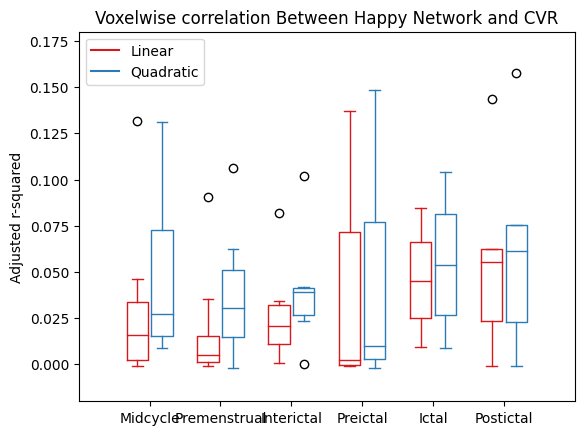

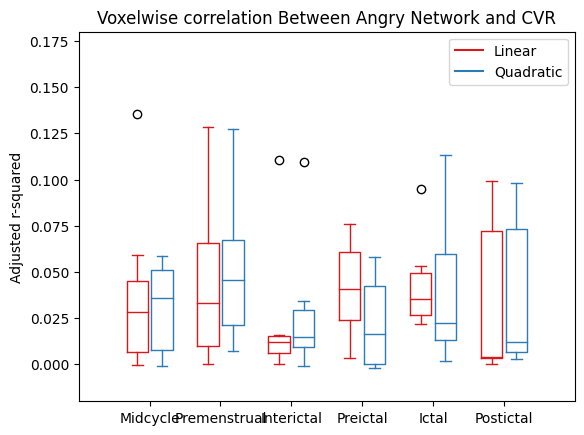

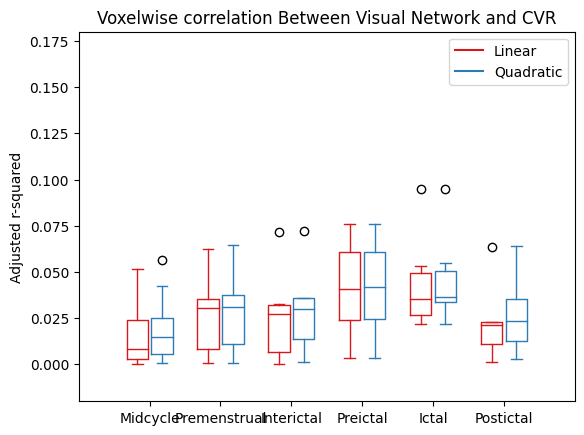

<Figure size 640x480 with 0 Axes>

In [53]:
linearplotshappy = [CVRlinH_mid, CVRlinH_premens, CVRlinH_int,CVRlinH_preict,CVRlinH_ict,CVRlinH_postict]
linearplotsangry = [CVRlinA_mid, CVRlinA_premens, CVRlinA_int,CVRlinV_preict,CVRlinV_ict,CVRlinA_postict]
linearplotsvis = [CVRlinV_mid, CVRlinV_premens,CVRlinV_int,CVRlinV_preict,CVRlinV_ict,CVRlinV_postict]

quadplotshappy = [CVRquadH_mid, CVRquadH_premens, CVRquadH_int,CVRquadH_preict, CVRquadH_ict, CVRquadH_postict]
quadplotsangry = [CVRquadA_mid, CVRquadA_premens, CVRquadA_int,CVRquadA_preict, CVRquadA_ict, CVRquadA_postict]
quadplotsvis = [CVRquadV_mid, CVRquadV_premens, CVRquadV_int,CVRquadV_preict, CVRquadV_ict, CVRquadV_postict]

boxplots2(linearplotshappy,quadplotshappy,'Happy Network','CVR')
boxplots2(linearplotsangry,quadplotsangry,"Angry Network","CVR")
boxplots2(linearplotsvis,quadplotsvis,'Visual Network','CVR')